# Load packages

In [1]:
import numpy as np
import torch
import sys
from matplotlib import pyplot as plt
import os
from IPython.display import clear_output
sys.path.append('..')
import lfi
from lfi.utils import *
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)
torch.set_grad_enabled(False)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
dataset = np.load(os.path.join('..','datasets','HIGGS.npy'))
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5170877, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5829122, 28)
dataset_P = MatConvert(dataset_P, device, dtype)
dataset_Q = MatConvert(dataset_Q, device, dtype)

# Higgs features

In [3]:
features = ['lepton pT', 
            'lepton eta', 
            'lepton phi', 
            'missing energy magnitude', 
            'missing energy phi', 
            'jet 1 pt', 
            'jet 1 eta', 
            'jet 1 phi', 
            'jet 1 b-tag', 
            'jet 2 pt', 
            'jet 2 eta', 
            'jet 2 phi', 
            'jet 2 b-tag', 
            'jet 3 pt', 
            'jet 3 eta', 
            'jet 3 phi', 
            'jet 3 b-tag', 
            'jet 4 pt', 
            'jet 4 eta',
            'jet 4 phi', 
            'jet 4 b-tag', 
            'm_jj',  
            'm_jjj', 
            'm_lv',  
            'm_jlv', 
            'm_bb',  
            'm_wbb',
            'm_wwbb'] 
# 2 decimal print
# feture_mean = np.round(np.mean(dataset, axis=0), 2)
# print('mean: ', feture_mean)


# Load Model

In [4]:
# Load the trained model
model_path = os.path.join('..','methods','Mix')
sys.path.append(model_path)
from model import *
n_tr = 1300000
model_number = 1
ckpt_path = os.path.join('..','methods','Mix','checkpoints','n_tr=%d#%d'%(n_tr,model_number),'kernel.pt')
kernel = torch.load(ckpt_path)

# Sample data

In [5]:
n_cal = 32768; n_ev = 32768
X_ev = dataset_P[ n_tr+np.random.choice(dataset_P.shape[0]-n_tr, n_ev, replace=False) ]
Y_ev = dataset_Q[ n_tr+np.random.choice(dataset_Q.shape[0]-n_tr, n_ev, replace=False) ]
X_opt = dataset_P[ n_tr+np.random.choice(dataset_P.shape[0]-n_tr, n_cal, replace=False) ]
Y_opt = dataset_Q[ n_tr+np.random.choice(dataset_Q.shape[0]-n_tr, n_cal, replace=False) ]
X_cal = dataset_P[ n_tr + np.random.choice(dataset_P.shape[0]-n_tr, n_cal, replace=False) ]
Y_cal = dataset_Q[ n_tr + np.random.choice(dataset_Q.shape[0]-n_tr, n_cal, replace=False) ]

# Compute witness scores

In [6]:
pi = 0.1; m = 1000
X_opt_scores = kernel.compute_scores(X_ev, Y_ev, X_opt)
Y_opt_scores = kernel.compute_scores(X_ev, Y_ev, Y_opt) 
t_opt, thres_opt_list, pval_opt_list = get_thres_from_evaluated_scores(X_opt_scores, Y_opt_scores, pi, m)
X_scores = kernel.compute_scores(X_ev, Y_ev, X_cal).cpu().numpy()
Y_scores = kernel.compute_scores(X_ev, Y_ev, Y_cal).cpu().numpy()

# Plot invariant mass distribution

In [7]:
feature = 26

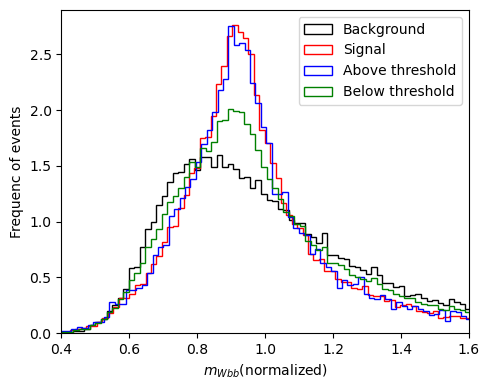

In [8]:
# Plot
Background = X_ev[:, feature].cpu().numpy()
Signal = Y_ev[:, feature].cpu().numpy()
Conditioned_to_signal = np.concatenate([Background[X_scores>t_opt], Signal[Y_scores>t_opt]])
Conditioned_to_background = np.concatenate([Background[X_scores<t_opt], Signal[Y_scores<t_opt]])
bins = 500
alpha = 1
plt.figure(figsize=(5, 4), dpi=100)
plt.hist(Background, bins=bins, alpha=alpha, label='Background', density=True, color='black', histtype='step')
plt.hist(Signal, bins=bins, alpha=alpha, label='Signal', density=True, color='red', histtype='step')
plt.hist(Conditioned_to_signal, bins=bins, alpha=alpha, label='Above threshold', density=True, color='blue', histtype='step')
plt.hist(Conditioned_to_background, bins=bins, alpha=alpha, label='Below threshold', density=True, color='green', histtype='step')
plt.xlabel('$m_{Wbb}$(normalized)')
plt.ylabel('Frequenc of events')
plt.xlim(0.4, 1.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join('..','assets', 'm_wbb.pdf'), dpi=300)

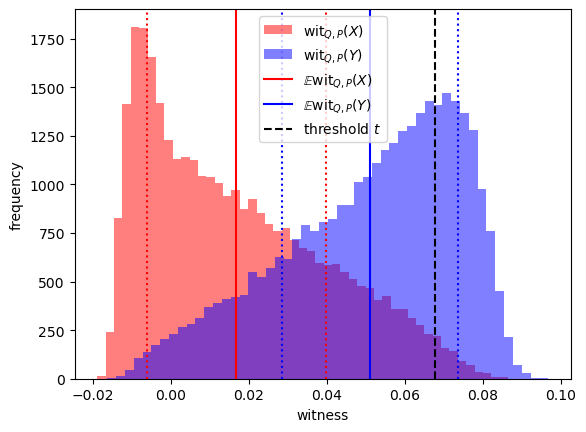

In [9]:
fig=plot_hist(X_scores, Y_scores, '../assets/hist.pdf', title='', pi=None, gamma=None, thres=t_opt, verbose=False, close=False)